In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import math
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

In [2]:
!unzip tf/data/test_data.zip

unzip:  cannot find or open tf/data/test_data.zip, tf/data/test_data.zip.zip or tf/data/test_data.zip.ZIP.


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N] - 1

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k]
        self.length = len(x)

        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [6]:
root_train = '../data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training'
root_test = '../data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing'
train_data_path = root_train + '/Train_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path1 = root_test + '/Test_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path2 = root_test + '/Test_Dst_NoAuction_ZScore_CF_8.txt'
test_data_path3 = root_test + '/Test_Dst_NoAuction_ZScore_CF_9.txt'


In [7]:
dec_data = np.loadtxt(train_data_path)
dec_test1 = np.loadtxt(test_data_path1)
dec_test2 = np.loadtxt(test_data_path2)
dec_test3 = np.loadtxt(test_data_path3)

dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

(149, 203800) (149, 50950) (149, 139587)


In [8]:
batch_size = 32

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([203701, 100, 40]) torch.Size([203701])


In [9]:
for x in dataset_train.x:
    if x.shape == [100, 40]:
        print(x.shape)

In [10]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 100, 40]) torch.Size([32])


In [11]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # 正则化
        self.fn = fn  # 具体的操作
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        # 前向传播
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    # attention
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads  # 计算最终进行全连接操作时输入神经元的个数
        project_out = not (heads == 1 and dim_head == dim)  # 多头注意力并且输入和输出维度相同时为True

        self.heads = heads  # 多头注意力中“头”的个数
        self.scale = dim_head ** -0.5  # 缩放操作，论文 Attention is all you need 中有介绍

        self.attend = nn.Softmax(dim = -1)  # 初始化一个Softmax操作
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)  # 对Q、K、V三组向量先进性线性操作

        # 线性全连接，如果不是多头或者输入输出维度不相等，进行空操作
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads  # 获得输入x的维度和多头注意力的“头”数
        qkv = self.to_qkv(x).chunk(3, dim = -1)  # 先对Q、K、V进行线性操作，然后chunk乘三三份
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)  # 整理维度，获得Q、K、V

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale  # Q, K 向量先做点乘，来计算相关性，然后除以缩放因子

        attn = self.attend(dots)  # 做Softmax运算

        out = einsum('b h i j, b h j d -> b h i d', attn, v)  # Softmax运算结果与Value向量相乘，得到最终结果
        out = rearrange(out, 'b h n d -> b n (h d)')  # 重新整理维度
        return self.to_out(out)  # 做线性的全连接操作或者空操作（空操作直接输出out）

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])  # Transformer包含多个编码器的叠加
        for _ in range(depth):
            # 编码器包含两大块：自注意力模块和前向传播模块
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),  # 多头自注意力模块
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))  # 前向传播模块
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            # 自注意力模块和前向传播模块都使用了残差的模式
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, num_classes=3, dim=256, depth=6, heads=16, mlp_dim=512, pool = 'cls', channels = 3, dim_head = 64, dropout = 0.1, emb_dropout = 0.1):
        super().__init__()
        num_patches = 100  # 获取图像切块的个数
        patch_dim = 40  # 线性变换时的输入大小，即每一个图像宽、高、通道的乘积
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'  # 池化方法必须为cls或者mean

        self.to_patch_embedding = nn.Sequential(
            nn.Linear(patch_dim, dim),  # 对分割好的图像块进行线性处理（全连接），输入维度为每一个小块的所有像素个数，输出为dim（函数传入的参数）
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))  # 位置编码，获取一组正态分布的数据用于训练
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # 分类令牌，可训练
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)  # Transformer模块

        self.pool = pool
        self.to_latent = nn.Identity()  # 占位操作

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),  # 正则化
            nn.Linear(dim, num_classes)  # 线性输出
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)  # 切块操作，shape (b, n, dim)，b为批量，n为切块数目，dim为最终线性操作时输入的神经元个数
        b, n, _ = x.shape  # shape (b, n, 1024)

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)  # 分类令牌，将self.cls_token（形状为1, 1, dim）赋值为shape (b, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1)  # 将分类令牌拼接到输入中，x的shape (b, n+1, 1024)
        x += self.pos_embedding[:, :(n + 1)]  # 进行位置编码，shape (b, n+1, 1024)
        x = self.dropout(x)

        x = self.transformer(x)  # transformer操作

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)  # 线性输出


In [12]:
model = ViT().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print(inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64) 
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, './best_val_model_pytorch')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses


In [15]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=20)

  5%|▌         | 1/20 [03:54<1:14:11, 234.30s/it]

model saved
Epoch 1/20, Train Loss: 0.9838,           Validation Loss: 1.0722, Duration: 0:03:54.302046, Best Val Epoch: 0


 10%|█         | 2/20 [07:50<1:10:38, 235.49s/it]

model saved
Epoch 2/20, Train Loss: 0.9458,           Validation Loss: 1.0647, Duration: 0:03:56.324502, Best Val Epoch: 1


 15%|█▌        | 3/20 [11:47<1:06:50, 235.93s/it]

model saved
Epoch 3/20, Train Loss: 0.9391,           Validation Loss: 1.0249, Duration: 0:03:56.457725, Best Val Epoch: 2


 20%|██        | 4/20 [15:43<1:02:56, 236.02s/it]

model saved
Epoch 4/20, Train Loss: 0.9229,           Validation Loss: 1.0203, Duration: 0:03:56.150343, Best Val Epoch: 3


 25%|██▌       | 5/20 [19:38<58:58, 235.91s/it]  

model saved
Epoch 5/20, Train Loss: 0.9077,           Validation Loss: 1.0118, Duration: 0:03:55.705810, Best Val Epoch: 4


 30%|███       | 6/20 [23:34<55:00, 235.78s/it]

Epoch 6/20, Train Loss: 0.8990,           Validation Loss: 1.0121, Duration: 0:03:55.521851, Best Val Epoch: 4


 35%|███▌      | 7/20 [27:30<51:04, 235.71s/it]

model saved
Epoch 7/20, Train Loss: 0.9063,           Validation Loss: 1.0061, Duration: 0:03:55.564634, Best Val Epoch: 6


 40%|████      | 8/20 [31:25<47:08, 235.74s/it]

model saved
Epoch 8/20, Train Loss: 0.8675,           Validation Loss: 1.0027, Duration: 0:03:55.809695, Best Val Epoch: 7


 45%|████▌     | 9/20 [35:21<43:13, 235.74s/it]

model saved
Epoch 9/20, Train Loss: 0.8356,           Validation Loss: 0.9829, Duration: 0:03:55.744636, Best Val Epoch: 8


 50%|█████     | 10/20 [39:17<39:17, 235.77s/it]

model saved
Epoch 10/20, Train Loss: 0.8179,           Validation Loss: 0.9607, Duration: 0:03:55.832451, Best Val Epoch: 9


 55%|█████▌    | 11/20 [43:12<35:21, 235.69s/it]

model saved
Epoch 11/20, Train Loss: 0.8118,           Validation Loss: 0.9266, Duration: 0:03:55.510908, Best Val Epoch: 10


 60%|██████    | 12/20 [47:08<31:24, 235.57s/it]

Epoch 12/20, Train Loss: 0.8215,           Validation Loss: 0.9872, Duration: 0:03:55.300338, Best Val Epoch: 10


 65%|██████▌   | 13/20 [51:03<27:28, 235.54s/it]

model saved
Epoch 13/20, Train Loss: 0.8038,           Validation Loss: 0.9110, Duration: 0:03:55.476182, Best Val Epoch: 12


 70%|███████   | 14/20 [54:59<23:33, 235.54s/it]

Epoch 14/20, Train Loss: 0.7894,           Validation Loss: 0.9197, Duration: 0:03:55.523465, Best Val Epoch: 12


 75%|███████▌  | 15/20 [58:54<19:37, 235.53s/it]

Epoch 15/20, Train Loss: 0.7851,           Validation Loss: 0.9136, Duration: 0:03:55.500554, Best Val Epoch: 12


 80%|████████  | 16/20 [1:02:50<15:41, 235.48s/it]

Epoch 16/20, Train Loss: 0.7807,           Validation Loss: 0.9528, Duration: 0:03:55.364460, Best Val Epoch: 12


 85%|████████▌ | 17/20 [1:06:45<11:46, 235.42s/it]

Epoch 17/20, Train Loss: 0.7804,           Validation Loss: 0.9405, Duration: 0:03:55.288940, Best Val Epoch: 12


 90%|█████████ | 18/20 [1:10:40<07:50, 235.30s/it]

Epoch 18/20, Train Loss: 0.8120,           Validation Loss: 0.9410, Duration: 0:03:55.007566, Best Val Epoch: 12


 95%|█████████▌| 19/20 [1:14:35<03:55, 235.19s/it]

Epoch 19/20, Train Loss: 0.7935,           Validation Loss: 0.9276, Duration: 0:03:54.948731, Best Val Epoch: 12


100%|██████████| 20/20 [1:18:30<00:00, 235.51s/it]

Epoch 20/20, Train Loss: 0.7770,           Validation Loss: 0.9338, Duration: 0:03:54.910625, Best Val Epoch: 12


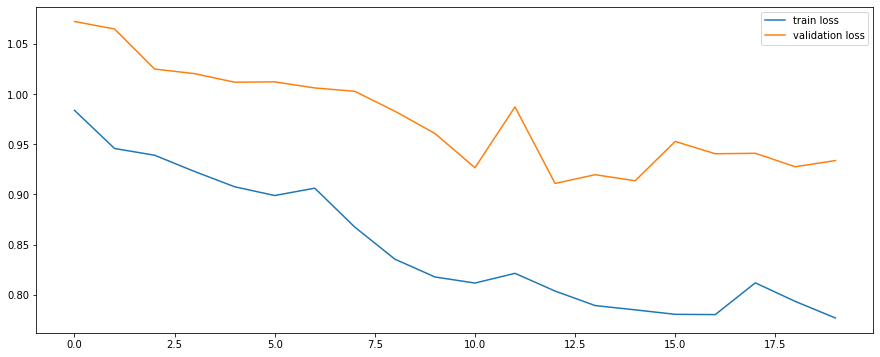

In [16]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [17]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.6153


In [18]:

# model = torch.load('best_val_model_pytorch')
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

In [19]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))


accuracy_score: 0.61529307180546
              precision    recall  f1-score   support

           0     0.5919    0.6311    0.6109     47915
           1     0.6859    0.6140    0.6480     48050
           2     0.5747    0.5992    0.5867     43523

    accuracy                         0.6153    139488
   macro avg     0.6175    0.6148    0.6152    139488
weighted avg     0.6189    0.6153    0.6161    139488



In [20]:
np.savetxt('train_losses_vit0.01_10.txt', train_losses)
np.savetxt('test_losses_vit0.01_k10.txt', val_losses)